Import Libraries


In [ ]:
!pip install tensorflow-addons
!pip install tensorflow==2.0.0-beta1

     |████████████████████████████████| 1.1 MB 32.5 MB/s 
ERROR: Could not find a version that satisfies the requirement tensorflow==2.0.0-beta1 (from versions: 1.13.1, 1.13.2, 1.14.0, 1.15.0, 1.15.2, 1.15.3, 1.15.4, 1.15.5, 2.0.0, 2.0.1, 2.0.2, 2.0.3, 2.0.4, 2.1.0, 2.1.1, 2.1.2, 2.1.3, 2.1.4, 2.2.0rc0, 2.2.0rc1, 2.2.0rc2, 2.2.0rc3, 2.2.0rc4, 2.2.0, 2.2.1, 2.2.2, 2.2.3, 2.3.0rc0, 2.3.0rc1, 2.3.0rc2, 2.3.0, 2.3.1, 2.3.2, 2.3.3, 2.3.4, 2.4.0rc0, 2.4.0rc1, 2.4.0rc2, 2.4.0rc3, 2.4.0rc4, 2.4.0, 2.4.1, 2.4.2, 2.4.3, 2.4.4, 2.5.0rc0, 2.5.0rc1, 2.5.0rc2, 2.5.0rc3, 2.5.0, 2.5.1, 2.5.2, 2.6.0rc0, 2.6.0rc1, 2.6.0rc2, 2.6.0, 2.6.1, 2.6.2, 2.7.0rc0, 2.7.0rc1, 2.7.0)
ERROR: No matching distribution found for tensorflow==2.0.0-beta1


In [ ]:
import tensorflow as tf
from tensorflow import keras
from keras.layers import LSTM, Conv2D, Activation, Concatenate, Conv2DTranspose, LeakyReLU, Input
from keras.models import Model

from keras.models import Sequential 
from tensorflow.keras.optimizers import Adam
#import tensorflow_addons as tfa

import tensorflow_datasets as tfds
import os
import time
import matplotlib.pyplot as plt
from IPython.display import clear_output

from os import listdir
import numpy as np
from numpy import asarray
from numpy import vstack
from numpy import ones
from numpy import zeros
from keras.preprocessing.image import img_to_array
from keras.preprocessing.image import load_img
from numpy import savez_compressed

import random
from random import randint

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!ls "/content/drive/My Drive/dataset"

small_test_cats  small_train_cats  test_cats  train_cats
small_test_dogs  small_train_dogs  test_dogs  train_dogs


In [ ]:
# load all images in a directory into memory
def load_images(path, size=(256,256)):
	data_list = list()
	# enumerate filenames in directory, assume all are images
	for filename in listdir(path):
		# load and resize the image
		pixels = load_img(path + filename, target_size=size)
		# convert to numpy array
		pixels = img_to_array(pixels)
		# store
		data_list.append(pixels)
	return asarray(data_list)

In [ ]:
# dataset path
path = '/content/drive/My Drive/dataset/'
# load dataset A
dataA1 = load_images(path + 'small_train_cats/')
dataAB = load_images(path + 'small_test_cats/')
dataA = vstack((dataA1, dataAB))
print('Loaded dataA: ', dataA.shape)
# load dataset B
dataB1 = load_images(path + 'small_train_dogs/')
dataB2 = load_images(path + 'small_test_dogs/')
dataB = vstack((dataB1, dataB2))
print('Loaded dataB: ', dataB.shape)
# save as compressed numpy array
filename = 'catstodogs_256.npz'
savez_compressed(filename, dataA, dataB)
print('Saved dataset: ', filename)

Loaded dataA:  (1250, 256, 256, 3)
Loaded dataB:  (1250, 256, 256, 3)
Saved dataset:  catstodogs_256.npz


Loaded:  (1250, 256, 256, 3) (1250, 256, 256, 3)


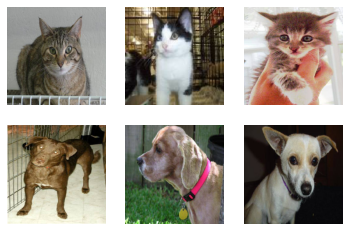

In [ ]:

# load and plot the prepared dataset
from numpy import load
from matplotlib import pyplot
# load the dataset
data = load('catstodogs_256.npz')
dataA, dataB = data['arr_0'], data['arr_1']
print('Loaded: ', dataA.shape, dataB.shape)
# plot source images
n_samples = 3
for i in range(n_samples):
	pyplot.subplot(2, n_samples, 1 + i)
	pyplot.axis('off')
	pyplot.imshow(dataA[i].astype('uint8'))
# plot target image
for i in range(n_samples):
	pyplot.subplot(2, n_samples, 1 + n_samples + i)
	pyplot.axis('off')
	pyplot.imshow(dataB[i].astype('uint8'))
pyplot.show()

In [ ]:

# define the discriminator model
def define_discriminator(image_shape):
	# weight initialization
	init = tf.keras.initializers.RandomNormal(stddev=0.02)
	# source image input
	in_image = tf.keras.Input(shape=image_shape)
	# C64
	d = Conv2D(64, (4,4), strides=(2,2), padding='same', kernel_initializer=init)(in_image)
	d = LeakyReLU(alpha=0.2)(d)
	# C128
	d = Conv2D(128, (4,4), strides=(2,2), padding='same', kernel_initializer=init)(d)
	#d = InstanceNormalization(axis=-1)(d)
	d = LeakyReLU(alpha=0.2)(d)
	# C256
	d = Conv2D(256, (4,4), strides=(2,2), padding='same', kernel_initializer=init)(d)
	#d = InstanceNormalization(axis=-1)(d)
	d = LeakyReLU(alpha=0.2)(d)
	# C512
	d = Conv2D(512, (4,4), strides=(2,2), padding='same', kernel_initializer=init)(d)
	#d = InstanceNormalization(axis=-1)(d)
	d = LeakyReLU(alpha=0.2)(d)
	# second last output layer
	d = Conv2D(512, (4,4), padding='same', kernel_initializer=init)(d)
	#d = InstanceNormalization(axis=-1)(d)
	d = LeakyReLU(alpha=0.2)(d)
	# patch output
	patch_out = Conv2D(1, (4,4), padding='same', kernel_initializer=init)(d)
	# define model
	model = Model(in_image, patch_out)
	# compile model
	model.compile(loss='mse', optimizer=Adam(lr=0.0002, beta_1=0.5), loss_weights=[0.5])
	return model

In [ ]:
def resnet_block(n_filters, input_layer):
	# weight initialization
	init = tf.keras.initializers.RandomNormal(stddev=0.02)
	# first layer convolutional layer
	g = Conv2D(n_filters, (3,3), padding='same', kernel_initializer=init)(input_layer)
	#g = InstanceNormalization(axis=-1)(g)
	g = Activation('relu')(g)
	# second convolutional layer
	g = Conv2D(n_filters, (3,3), padding='same', kernel_initializer=init)(g)
	#g = InstanceNormalization(axis=-1)(g)
	# concatenate merge channel-wise with input layer
	g = Concatenate()([g, input_layer])
	return g

In [ ]:

# define the standalone generator model
def define_generator(image_shape, n_resnet=9):
	# weight initialization
	init = tf.keras.initializers.RandomNormal(stddev=0.02)
	# image input
	in_image = tf.keras.Input(shape=image_shape)
	# c7s1-64
	g = Conv2D(64, (7,7), padding='same', kernel_initializer=init)(in_image)
	#g = tfa.layers.InstanceNormalization(axis=-1)(g)
	g = Activation('relu')(g)
	# d128
	g = Conv2D(128, (3,3), strides=(2,2), padding='same', kernel_initializer=init)(g)
	#g = tfa.layers.InstanceNormalization(axis=-1)(g)
	g = Activation('relu')(g)
	# d256
	g = Conv2D(256, (3,3), strides=(2,2), padding='same', kernel_initializer=init)(g)
	#g = tfa.layers.InstanceNormalization(axis=-1)(g)
	g = Activation('relu')(g)
	# R256
	for _ in range(n_resnet):
		g = resnet_block(256, g)
	# u128
	g = Conv2DTranspose(128, (3,3), strides=(2,2), padding='same', kernel_initializer=init)(g)
	#g = tfa.layers.InstanceNormalization(axis=-1)(g)
	g = Activation('relu')(g)
	# u64
	g = Conv2DTranspose(64, (3,3), strides=(2,2), padding='same', kernel_initializer=init)(g)
	#g = tfa.layers.InstanceNormalization(axis=-1)(g)
	g = Activation('relu')(g)
	# c7s1-3
	g = Conv2D(3, (7,7), padding='same', kernel_initializer=init)(g)
	#g = tfa.layers.InstanceNormalization(axis=-1)(g)
	out_image = Activation('tanh')(g)
	# define model
	model = Model(in_image, out_image)
	return model

In [ ]:

# define a composite model for updating generators by adversarial and cycle loss
def define_composite_model(g_model_1, d_model, g_model_2, image_shape):
	# ensure the model we're updating is trainable
	g_model_1.trainable = True
	# mark discriminator as not trainable
	d_model.trainable = False
	# mark other generator model as not trainable
	g_model_2.trainable = False
	# discriminator element
	input_gen = Input(shape=image_shape)
	gen1_out = g_model_1(input_gen)
	output_d = d_model(gen1_out)
	# identity element
	input_id = Input(shape=image_shape)
	output_id = g_model_1(input_id)
	# forward cycle
	output_f = g_model_2(gen1_out)
	# backward cycle
	gen2_out = g_model_2(input_id)
	output_b = g_model_1(gen2_out)
	# define model graph
	model = Model([input_gen, input_id], [output_d, output_id, output_f, output_b])
	# define optimization algorithm configuration
	opt = Adam(lr=0.0002, beta_1=0.5)
	# compile model with weighting of least squares loss and L1 loss
	model.compile(loss=['mse', 'mae', 'mae', 'mae'], loss_weights=[1, 5, 10, 10], optimizer=opt)
	return model

In [ ]:

# load and prepare training images
def load_real_samples(filename):
	# load the dataset
	data = load(filename)
	# unpack arrays
	X1, X2 = data['arr_0'], data['arr_1']
	# scale from [0,255] to [-1,1]
	X1 = (X1 - 127.5) / 127.5
	X2 = (X2 - 127.5) / 127.5
	return [X1, X2]

In [ ]:

# select a batch of random samples, returns images and target
def generate_real_samples(dataset, n_samples, patch_shape):
	# choose random instances
	ix = np.random.randint(0, dataset.shape[0], n_samples)
	# retrieve selected images
	X = dataset[ix]
	# generate 'real' class labels (1)
	y = ones((n_samples, patch_shape, patch_shape, 1))
	return X, y

In [ ]:

# generate a batch of images, returns images and targets
def generate_fake_samples(g_model, dataset, patch_shape):
	# generate fake instance
	X = g_model.predict(dataset)
	# create 'fake' class labels (0)
	y = zeros((len(X), patch_shape, patch_shape, 1))
	return X, y

In [ ]:

# save the generator models to file
def save_models(step, g_model_AtoB, g_model_BtoA):
	# save the first generator model
	filename1 = 'g_model_AtoB_%06d.h5' % (step+1)
	g_model_AtoB.save(filename1)
	# save the second generator model
	filename2 = 'g_model_BtoA_%06d.h5' % (step+1)
	g_model_BtoA.save(filename2)
	print('>Saved: %s and %s' % (filename1, filename2))

In [ ]:

# generate samples and save as a plot and save the model
def summarize_performance(step, g_model, trainX, name, n_samples=5):
	# select a sample of input images
	X_in, _ = generate_real_samples(trainX, n_samples, 0)
	# generate translated images
	X_out, _ = generate_fake_samples(g_model, X_in, 0)
	# scale all pixels from [-1,1] to [0,1]
	X_in = (X_in + 1) / 2.0
	X_out = (X_out + 1) / 2.0
	# plot real images
	for i in range(n_samples):
		pyplot.subplot(2, n_samples, 1 + i)
		pyplot.axis('off')
		pyplot.imshow(X_in[i])
	# plot translated image
	for i in range(n_samples):
		pyplot.subplot(2, n_samples, 1 + n_samples + i)
		pyplot.axis('off')
		pyplot.imshow(X_out[i])
	# save plot to file
	filename1 = '%s_generated_plot_%06d.png' % (name, (step+1))
	pyplot.savefig(filename1)
	pyplot.close()

In [ ]:

# update image pool for fake images
def update_image_pool(pool, images, max_size=30):
	selected = list()
	for i in images:
		if len(pool) < max_size:
			# stock the pool
			pool.append(i)
			selected.append(i)
		#elif random() < 0.5:
			# use image, but don't add it to the pool
			#selected.append(i)
		else:
			# replace an existing image and use replaced image
			ix = randint(0, len(pool))
			selected.append(pool[ix])
			pool[ix] = i
	return asarray(selected)

In [ ]:
def train(d_model_A, d_model_B, g_model_AtoB, g_model_BtoA, c_model_AtoB, c_model_BtoA, dataset):
	# define properties of the training run
	n_epochs, n_batch, = 1, 1
	# determine the output square shape of the discriminator
	n_patch = d_model_A.output_shape[1]
	# unpack dataset
	trainA, trainB = dataset
	# prepare image pool for fakes
	poolA, poolB = list(), list()
	# calculate the number of batches per training epoch
	bat_per_epo = int(len(trainA) / n_batch)
	# calculate the number of training iterations
	n_steps = bat_per_epo * n_epochs
	# manually enumerate epochs
	for i in range(n_steps):
		# select a batch of real samples
		X_realA, y_realA = generate_real_samples(trainA, n_batch, n_patch)
		X_realB, y_realB = generate_real_samples(trainB, n_batch, n_patch)
		# generate a batch of fake samples
		X_fakeA, y_fakeA = generate_fake_samples(g_model_BtoA, X_realB, n_patch)
		X_fakeB, y_fakeB = generate_fake_samples(g_model_AtoB, X_realA, n_patch)
		# update fakes from pool
		X_fakeA = update_image_pool(poolA, X_fakeA)
		X_fakeB = update_image_pool(poolB, X_fakeB)
		# update generator B->A via adversarial and cycle loss
		g_loss2, _, _, _, _  = c_model_BtoA.train_on_batch([X_realB, X_realA], [y_realA, X_realA, X_realB, X_realA])
		# update discriminator for A -> [real/fake]
		dA_loss1 = d_model_A.train_on_batch(X_realA, y_realA)
		dA_loss2 = d_model_A.train_on_batch(X_fakeA, y_fakeA)
		# update generator A->B via adversarial and cycle loss
		g_loss1, _, _, _, _ = c_model_AtoB.train_on_batch([X_realA, X_realB], [y_realB, X_realB, X_realA, X_realB])
		# update discriminator for B -> [real/fake]
		dB_loss1 = d_model_B.train_on_batch(X_realB, y_realB)
		dB_loss2 = d_model_B.train_on_batch(X_fakeB, y_fakeB)
		# summarize performance
		print('>%d, dA[%.3f,%.3f] dB[%.3f,%.3f] g[%.3f,%.3f]' % (i+1, dA_loss1,dA_loss2, dB_loss1,dB_loss2, g_loss1,g_loss2))
		# evaluate the model performance every so often
		if (i+1) % (bat_per_epo * 1) == 0:
			# plot A->B translation
			summarize_performance(i, g_model_AtoB, trainA, 'AtoB')
			# plot B->A translation
			summarize_performance(i, g_model_BtoA, trainB, 'BtoA')
		if (i+1) % (bat_per_epo * 3) == 0:
			# save the models
			save_models(i, g_model_AtoB, g_model_BtoA)

In [ ]:
# load image data
dataset = load_real_samples('catstodogs_256.npz')
print('Loaded', dataset[0].shape, dataset[1].shape)
# define input shape based on the loaded dataset
image_shape = dataset[0].shape[1:]

Loaded (1250, 256, 256, 3) (1250, 256, 256, 3)


In [ ]:
# generator: A -> B
g_model_AtoB = define_generator(image_shape)
# generator: B -> A
g_model_BtoA = define_generator(image_shape)
# discriminator: A -> [real/fake]
d_model_A = define_discriminator(image_shape)
# discriminator: B -> [real/fake]
d_model_B = define_discriminator(image_shape)
# composite: A -> B -> [real/fake, A]
c_model_AtoB = define_composite_model(g_model_AtoB, d_model_B, g_model_BtoA, image_shape)
# composite: B -> A -> [real/fake, B]
c_model_BtoA = define_composite_model(g_model_BtoA, d_model_A, g_model_AtoB, image_shape)


/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


In [ ]:
# train models
train(d_model_A, d_model_B, g_model_AtoB, g_model_BtoA, c_model_AtoB, c_model_BtoA, dataset)

>1, dA[0.514,0.000] dB[0.495,0.000] g[9.476,8.968]
>2, dA[0.168,0.019] dB[0.161,0.019] g[10.439,11.047]
>3, dA[0.326,0.871] dB[0.754,0.022] g[10.470,20.419]
>4, dA[0.320,0.000] dB[0.200,0.008] g[15.100,15.175]
>5, dA[0.383,0.000] dB[0.297,0.190] g[11.597,9.828]
>6, dA[0.243,0.003] dB[0.293,0.012] g[10.495,11.390]
>7, dA[0.146,0.012] dB[0.395,0.005] g[9.264,9.928]
>8, dA[4.311,0.002] dB[0.053,0.010] g[15.395,15.197]
>9, dA[0.341,0.000] dB[0.065,0.480] g[10.400,12.514]
>10, dA[0.308,0.000] dB[0.332,0.000] g[13.469,13.348]
>11, dA[0.237,0.001] dB[0.163,0.002] g[11.089,11.567]
>12, dA[0.203,0.001] dB[0.807,0.002] g[11.307,11.661]
>13, dA[0.175,0.002] dB[0.449,0.001] g[11.098,11.904]
>14, dA[0.135,0.007] dB[0.425,0.001] g[9.148,9.229]
>15, dA[0.331,0.002] dB[0.369,0.026] g[9.096,10.029]
>16, dA[0.195,0.006] dB[0.246,0.172] g[11.079,10.553]
>17, dA[0.171,0.002] dB[0.095,0.003] g[12.349,11.714]
>18, dA[0.124,0.007] dB[0.270,0.016] g[11.211,12.331]
>19, dA[0.070,0.302] dB[0.222,0.012] g[10.933

In [ ]:

...
# load dataset
A_data, B_data = load_real_samples('catstodogs_256.npz')
print('Loaded', A_data.shape, B_data.shape)

In [ ]:
...
# load the models
cust = {'InstanceNormalization': InstanceNormalization}
model_AtoB = load_model('g_model_AtoB_089025.h5', cust)
model_BtoA = load_model('g_model_BtoA_089025.h5', cust)

In [ ]:
def select_sample(dataset, n_samples):
	# choose random instances
	ix = randint(0, dataset.shape[0], n_samples)
	# retrieve selected images
	X = dataset[ix]
	return X

In [ ]:
# plot A->B->A
A_real = select_sample(A_data, 1)
B_generated  = model_AtoB.predict(A_real)
A_reconstructed = model_BtoA.predict(B_generated)

In [ ]:
def show_plot(imagesX, imagesY1, imagesY2):
	images = vstack((imagesX, imagesY1, imagesY2))
	titles = ['Real', 'Generated', 'Reconstructed']
	# scale from [-1,1] to [0,1]
	images = (images + 1) / 2.0
	# plot images row by row
	for i in range(len(images)):
		# define subplot
		pyplot.subplot(1, len(images), 1 + i)
		# turn off axis
		pyplot.axis('off')
		# plot raw pixel data
		pyplot.imshow(images[i])
		# title
		pyplot.title(titles[i])
	pyplot.show()

In [ ]:
show_plot(A_real, B_generated, A_reconstructed)